In [79]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline

In [80]:
val = pd.read_csv("/ecosystem-embedding/training/valid_clustered_vf.csv")
test = pd.read_csv("/ecosystem-embedding/training/test_clustered_vf.csv")

In [81]:
geoDatav = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')


In [82]:
preds_path = "/network/projects/_groups/ecosystem-embeddings/ebird_checkpoints/resnet18_location_env_400_epochs/preds"
preds2_path="/ecosystem-embeddings/preds_sat_env_landuse"

In [83]:
path = "/network/projects/_groups/ecosystem-embeddings/data/hotspot_data/hotspots_june_filtered.csv"
df = pd.read_csv(path)
df = df.drop_duplicates("hotspot_id")

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)   
gdf["split"] = ""
idx = gdf[gdf["hotspot_id"].isin(list(val["hotspot"]))].index
gdf.loc[idx,"split"] = "val"
idx = gdf[gdf["hotspot_id"].isin(list(test["hotspot"]))].index
gdf.loc[idx,"split"] = "test"


In [6]:
gdf

,Unnamed: 0,hotspot_id,lon,lat,county,county_code,state,state_code,june_complete_checklists,num_checklists,num_complete_checklists,num_different_species,geometry,split
0,0,L8838283,-84.385593,33.994190,Fulton,US-GA-121,Georgia,US-GA,6,69,61,85,POINT (-84.38559 33.99419),
1,1,L1184986,-89.344747,41.879627,Lee,US-IL-103,Illinois,US-IL,86,175,168,138,POINT (-89.34475 41.87963),val
2,2,L2626716,-122.840409,45.735062,Columbia,US-OR-009,Oregon,US-OR,5,116,106,126,POINT (-122.84041 45.73506),
3,3,L575194,-72.524126,42.590658,Franklin,US-MA-011,Massachusetts,US-MA,40,322,285,131,POINT (-72.52413 42.59066),
4,4,L925049,-76.630036,39.321150,Baltimore,US-MD-005,Maryland,US-MD,28,401,321,98,POINT (-76.63004 39.32115),val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8633,8633,L2146581,-123.084710,39.002042,Mendocino,US-CA-045,California,US-CA,141,3013,2327,218,POINT (-123.08471 39.00204),
8634,8634,L283109,-90.417566,38.893171,St. Charles,US-MO-183,Missouri,US-MO,41,421,366,233,POINT (-90.41757 38.89317),
8635,8635,L513743,-75.411090,39.812253,Delaware,US-PA-045,Pennsylvania,US-PA,10,342,318,138,POINT (-75.41109 39.81225),
8636,8636,L522347,-121.765240,36.572932,Monterey,US-CA-053,California,US-CA,10,251,193,150,POINT (-121.76524 36.57293),


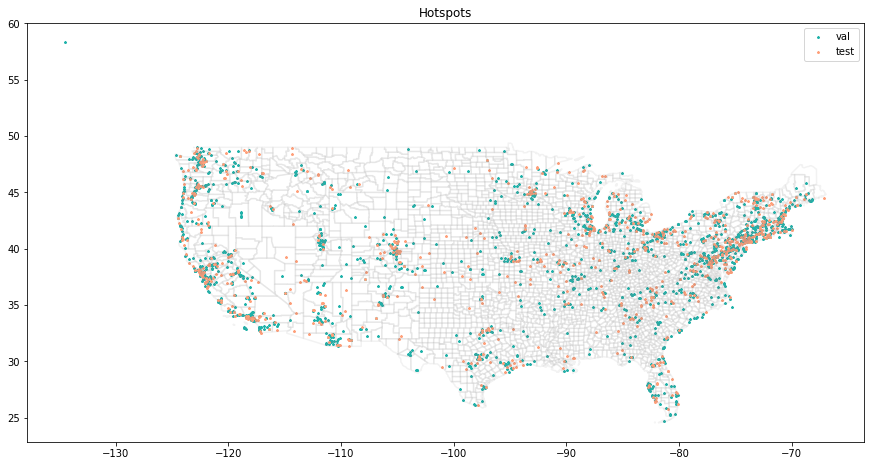

In [6]:
fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
#gdf[gdf["split"]=="train"].plot(ax=ax,marker='*', color='yellowgreen', markersize=5, label = "train")
gdf[gdf["split"]=="val"].plot(ax=ax, marker='*', color='lightseagreen', markersize=5, label = "val")
gdf[gdf["split"]=="test"].plot(ax=ax, marker='*', color='lightsalmon', markersize=5, label = "test")

plt.legend()
plt.title("Hotspots")
plt.show()

In [84]:
test_hotspots = test["hotspot"].values
val_hotspots = val["hotspot"].values

In [85]:
preds_files =[os.path.join(preds_path, hs + ".npy") for hs in test_hotspots]

In [86]:
# format predictions as n_samples * features
preds_array = np.zeros((len(preds_files), 379))

In [87]:
hs_list = []
i = 0
for hs in test_hotspots:
    path = os.path.join(preds_path, hs + ".npy") 
    if os.path.exists(path):
        pred = np.load(path)
        hs_list += [path]
        preds_array[i, :] = pred
        i += 1

In [11]:
preds_array.shape

(843, 379)

In [77]:
preds2_array = np.zeros((len(preds_files), 379))
hs_list = []
i = 0
for hs in test_hotspots:
    path = os.path.join(preds2_path, hs + ".npy") 
    if os.path.exists(path):
        pred = np.load(path)
        hs_list += [path]
        preds2_array[i, :] = pred
        i += 1

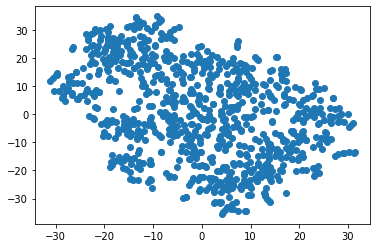

In [88]:
import sklearn.manifold 
from PIL import Image

TSNE = sklearn.manifold.TSNE(n_components=2)
out = TSNE.fit_transform(preds_array)
TSNE = sklearn.manifold.TSNE(n_components=3)
out3d = TSNE.fit_transform(preds_array)
df2 = pd.DataFrame()
df2["comp-1"] = out3d[:,0]
df2["comp-2"] = out3d[:,1]
df2["comp-3"] = out3d[:,2]


fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
ax=fig.add_subplot()

ax.scatter(out[:,0],out[:,1] )
           #c = maj_landuse)


In [89]:
out

array([[-18.861013,  19.232275],
       [ 13.254109,  -8.926534],
       [-12.877877,  33.28211 ],
       ...,
       [ -9.694306,  31.134865],
       [-17.775318, -16.785421],
       [ -8.017968,   4.071716]], dtype=float32)

In [90]:
maj_landuse = []
for i, row in test.iterrows():
    a = np.array(Image.open(test["landuse"][i]))
    values, counts = np.unique(a, return_counts=True)
    ind = np.argmax(counts)
    maj_landuse += [values[ind]]
#gdf["maj_landuse"] = 0
test_gdf = gdf[gdf["split"]=="test"].copy()
test_gdf["maj_landuse"] = maj_landuse

In [91]:
test_df = test[['hotspot_id', "june_complete_checklists", 'rgb', "species"]]

test_gdf = gdf[gdf["split"]=="test"]

test_df["maj_landuse"] = maj_landuse

test_df = test_df.merge(test_gdf[['hotspot_id', 'lon', 'lat']])

not_songbird_idx = np.load("/network/projects/_groups/ecosystem-embeddings/species_splits/not_songbirds_idx.npy")

test_df["mae"] = 0
test_df["mse"] = 0
test_df["non_zero"] = 0
test_df["topk"] = 0
for i, row in test_df.iterrows():
    preds = np.load(preds_files[i])
    
    with open(row["species"]) as f:
        gt = json.load(f)["probs"]
    gt = np.array(gt)[not_songbird_idx]
    f.close()
    
    test_df.loc[i, "mae"] = np.sum(np.abs(preds - gt))
    test_df.loc[i, "mse"] = np.sum(np.square(preds - gt))
    nonzero = len(np.nonzero(gt)[0])
    if nonzero != 0 :
        test_df.loc[i,"non_zero"] = nonzero
    
        indices_pred = (-preds).argsort()[:nonzero]
        indices_gt = np.nonzero(gt)[0]

        test_df.loc[i,"topk"] = len([a for a in indices_pred if a in indices_gt])/nonzero
    else:
        test_df.loc[i,"topk"] = -1
    

/tmp/ipykernel_6947/1498606088.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["maj_landuse"] = maj_landuse


In [92]:
test_df

,hotspot_id,june_complete_checklists,rgb,species,maj_landuse,lon,lat,mae,mse,non_zero,topk
0,L758470,23,/network/scratch/t/tengmeli/scratch/ecosystem-...,/network/scratch/t/tengmeli/scratch/ecosystem-...,2,-78.134461,39.433037,2.867005,0.531920,19,0.842105
1,L1552663,165,/network/scratch/t/tengmeli/scratch/ecosystem-...,/network/scratch/t/tengmeli/scratch/ecosystem-...,7,-118.293936,33.787458,8.548416,3.243350,52,0.500000
2,L631813,20,/network/scratch/t/tengmeli/scratch/ecosystem-...,/network/scratch/t/tengmeli/scratch/ecosystem-...,2,-83.826842,34.226352,5.209877,2.007411,23,0.782609
3,L2204050,20,/network/scratch/t/tengmeli/scratch/ecosystem-...,/network/scratch/t/tengmeli/scratch/ecosystem-...,2,-83.718910,33.092002,5.014737,0.672176,24,0.750000
4,L526453,30,/network/scratch/t/tengmeli/scratch/ecosystem-...,/network/scratch/t/tengmeli/scratch/ecosystem-...,5,-89.403002,43.275705,3.907576,0.555465,24,0.625000
...,...,...,...,...,...,...,...,...,...,...,...
838,L1056903,20,/network/scratch/t/tengmeli/scratch/ecosystem-...,/network/scratch/t/tengmeli/scratch/ecosystem-...,5,-89.133110,40.348114,3.661452,0.884548,16,0.500000
839,L1161147,51,/network/scratch/t/tengmeli/scratch/ecosystem-...,/network/scratch/t/tengmeli/scratch/ecosystem-...,7,-85.630853,38.242528,4.527909,1.477069,23,0.608696
840,L5613429,8,/network/scratch/t/tengmeli/scratch/ecosystem-...,/network/scratch/t/tengmeli/scratch/ecosystem-...,2,-78.698566,36.893145,4.221385,1.060408,21,0.809524
841,L140939,10,/network/scratch/t/tengmeli/scratch/ecosystem-...,/network/scratch/t/tengmeli/scratch/ecosystem-...,1,-72.138977,41.035924,9.023991,3.615643,20,0.400000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


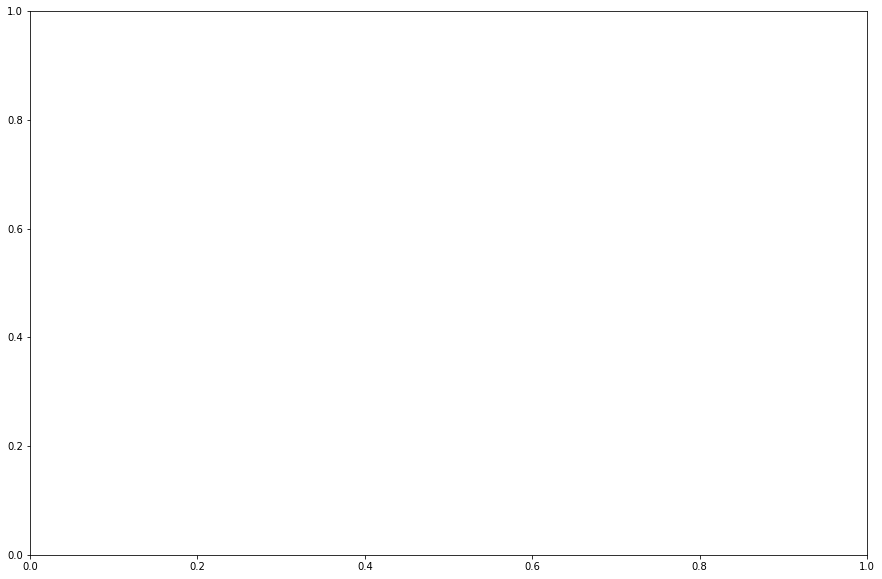

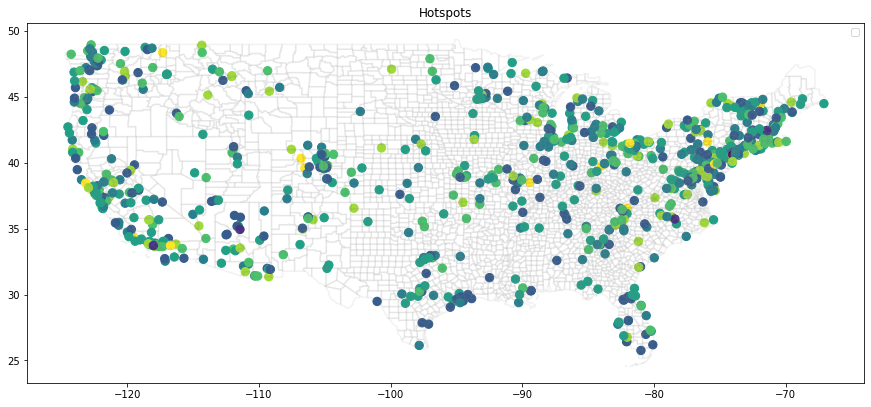

In [93]:
test_df["preds_"] = 7
test_df.loc[test_df["topk"]<0.85,"preds_"]  = 6
test_df.loc[test_df["topk"]<0.75,"preds_"]  = 5
test_df.loc[test_df["topk"]<0.65,"preds_"]  = 4
test_df.loc[test_df["topk"]<0.55,"preds_"]  = 3
test_df.loc[test_df["topk"]<0.45,"preds_"]  = 2
test_df.loc[test_df["topk"]==-1,"preds_"]  = 0
test_df.loc[test_df["topk"]==0,"preds_"]  = 1
fig, ax = plt.subplots(figsize =(15,10))
# #train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
# geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )

# # produce a legend with the unique colors from the scatter
# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="lower left", title="Landuse class")
# ax.add_artist(legend)
test_df["preds_"]= test_df["preds_"]/6
fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
#gdf[gdf["split"]=="train"].plot(ax=ax,marker='*', color='yellowgreen', markersize=5, label = "train")
test_gdf.plot(ax=ax, marker='o', c=test_df["preds_"], markersize=70, legend = True)#, label = legend1)

plt.legend()
plt.title("Hotspots")
plt.show()

In [ ]:
test_df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


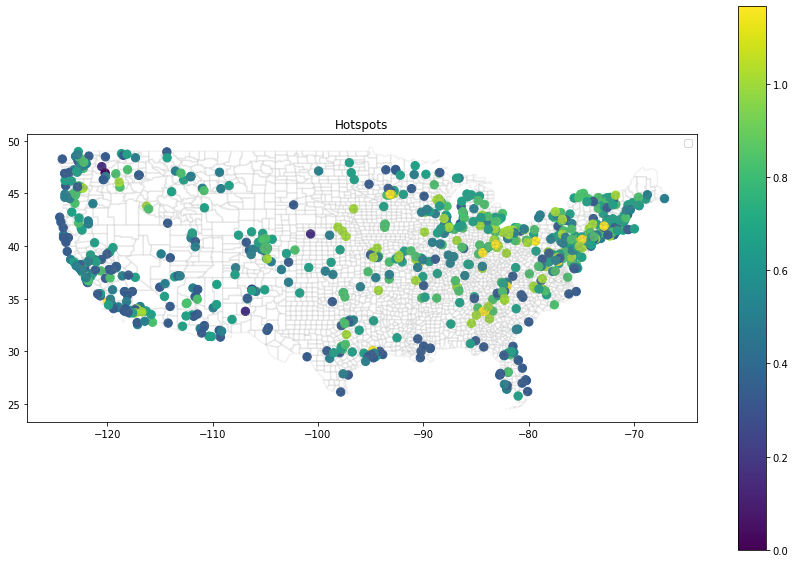

In [95]:
tt=test_gdf.merge(test_df[["hotspot_id","mae","mse", "topk", "preds_"]], left_on = "hotspot_id",right_on = "hotspot_id")

fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
#gdf[gdf["split"]=="train"].plot(ax=ax,marker='*', color='yellowgreen', markersize=5, label = "train")
tt.plot(ax=ax, column ="preds_", marker='o', c=tt["preds_"], markersize=70, legend= True)

plt.legend()
plt.title("Hotspots")
plt.show()

In [96]:
import pickle
from copy import deepcopy
with open('/ecosystem-embedding/training/final_range_map3.pkl','rb') as f:
            correction_data=pickle.load(f)
subset=np.load('/network/projects/_groups/ecosystem-embeddings/species_splits/not_songbirds_idx.npy')       
correction=  correction_data.iloc[:,subset]
hotspot_id=test_df['hotspot_id']
correction= correction[correction_data['hotspot_id'].isin(list(hotspot_id))].to_numpy()
pred=deepcopy(preds_array)
masked_pred=pred*correction

In [22]:
(pred==masked_pred).all()

False

In [78]:
import pickle
from copy import deepcopy
with open('/ecosystem-embedding/training/final_range_map3.pkl','rb') as f:
            correction_data=pickle.load(f)
subset=np.load('/network/projects/_groups/ecosystem-embeddings/species_splits/not_songbirds_idx.npy')       
correction=  correction_data.iloc[:,subset]
hotspot_id=test_df['hotspot_id']
correction= correction[correction_data['hotspot_id'].isin(list(hotspot_id))].to_numpy()
pred=deepcopy(preds2_array)
masked_pred=pred*correction
(pred==masked_pred).all()

False

In [ ]:
# import pickle
# import numpy as np
# with open("/network/scratch/t/tengmeli/scratch/ecosystem-embedding/training/final_range_map3.pkl",'rb') as f:
#     correction_data = pickle.load(f)
# not_songbird_idx = np.load("/network/projects/_groups/ecosystem-embeddings/species_splits/not_songbirds_idx.npy")
# test = pd.read_csv("/network/scratch/t/tengmeli/scratch/ecosystem-embedding/training/test_clustered_vf.csv")
# preds_path = "/network/projects/_groups/ecosystem-embeddings/ebird_checkpoints/resnet18_location_env_400_epochs/preds"

# for hs in test["hotspot_id"].values:
#     pred = np.load(os.path.join("/network/projects/_groups/ecosystem-embeddings/ebird_checkpoints/resnet18_location_env_400_epochs/preds/",  hs+ ".npy"))
#     correction = correction_data[correction_data["hotspot_id"]==hs].values[0,:-1][not_songbird_idx]
#     if (pred != (pred * correction)).sum() !=0:
#         print("mismatch")

## performance per species

In [97]:
#first lets get the ground truth (843,379)
gt=np.empty_like(preds_array)
for i, row in test_df.iterrows():
    
    with open(row["species"]) as f:
        gt_i = json.load(f)["probs"]
    gt_i = np.array(gt_i)[not_songbird_idx]
    gt[i,:]=gt_i
    f.close()


In [98]:
assert gt.shape==(843,379), 'wrong shape for gt'
assert preds_array.shape==(843,379), 'wrong shape for preds'

In [99]:
#apply range maps to both ground truth and preds array
import pickle
from copy import deepcopy
with open('/ecosystem-embedding/training/final_range_map3.pkl','rb') as f:
            correction_data=pickle.load(f)
subset=np.load('/network/projects/_groups/ecosystem-embeddings/species_splits/not_songbirds_idx.npy')       
correction=  correction_data.iloc[:,subset]
hotspot_id=test_df['hotspot_id']
correction= correction[correction_data['hotspot_id'].isin(list(hotspot_id))].to_numpy()
pred=deepcopy(preds_array)
masked_pred=pred*correction
gt*=correction


In [100]:
#transpose first
import torch
gt_t=torch.tensor(gt.transpose(1,0),device='cpu')
preds_array_t=torch.tensor(preds_array.transpose(1,0),device='cpu')

In [150]:
gt_t.shape

torch.Size([379, 843])

In [169]:
#calculate the mse,r2, topk across the first dimension=> result of shape(1,379)
import torch
from torchmetrics import MultioutputWrapper,MeanSquaredError,R2Score,PearsonCorrCoef,SpearmanCorrCoef
mse=MultioutputWrapper(MeanSquaredError(), 379)
r2=MultioutputWrapper(R2Score(), 379)
corr=MultioutputWrapper(PearsonCorrCoef(), 379)
rank=MultioutputWrapper(SpearmanCorrCoef(),379)
mse.to('cpu')
r2.to('cpu')
corr.to('cpu')
rank.to('cpu')

#assert gt.shape==(379, 843), 'wrong gt shape'
mse_per_species=mse(torch.tensor(gt),torch.tensor(preds_array))
r2_per_species=r2(torch.tensor(gt),torch.tensor(preds_array))
corr_per_species=corr(torch.tensor(gt),torch.tensor(preds_array))
rank_per_species=rank(torch.tensor(gt),torch.tensor(preds_array))

In [194]:
#fill nan values 
r2_per_species=np.nan_to_num(r2_per_species)
corr_per_species=np.nan_to_num(corr_per_species)
rank_per_species=np.nan_to_num(corr_per_species)

In [170]:
#species names for visualization
with open('/ecosystem-embedding/ebird_data/L10000991_complete_checklists.pkl', 'rb') as f:
    data = pickle.load(f)
names= data['SCIENTIFIC NAME'].unique()
#subset of nonsong birds
subset_names=names[subset]



In [195]:
#best and lowest species
lowest_ranks=subset_names[torch.tensor(rank_per_species).argsort()[:10]]
best_ranks=subset_names[torch.tensor(rank_per_species).argsort()[-10:]]

lowest_corr=subset_names[torch.tensor(corr_per_species).argsort()[:10]]
best_corr=subset_names[torch.tensor(corr_per_species).argsort()[-10:]]

lowest_r2=subset_names[torch.tensor(r2_per_species).argsort()[:10]]
best_r2=subset_names[torch.tensor(r2_per_species).argsort()[-10:]]

lowest_mse=subset_names[torch.tensor(mse_per_species).argsort()[:10]]
best_mse=subset_names[torch.tensor(mse_per_species).argsort()[-10:]]

In [ ]:
torch.tensor(corr_per_species).

In [196]:
#best and lowest species as well as scores
#best_corr,
scores_corr=np.array(corr_per_species)[torch.tensor(corr_per_species).argsort().numpy()[-10:]]
scores_corr_lowest=np.array(corr_per_species)[torch.tensor(corr_per_species).argsort().numpy()[:10]]

In [197]:
scores_corr,scores_corr_lowest

(array([0.7293629 , 0.73360705, 0.7714977 , 0.84259486, 0.8459165 ,
        0.90501964, 0.9243432 , 0.94437987, 0.9977263 , 0.99847674],
       dtype=float32),
 array([-0.04411731, -0.03985466, -0.03389713, -0.02790981, -0.0248776 ,
        -0.02078735, -0.02037648, -0.01980128, -0.01897656, -0.01805361],
       dtype=float32))

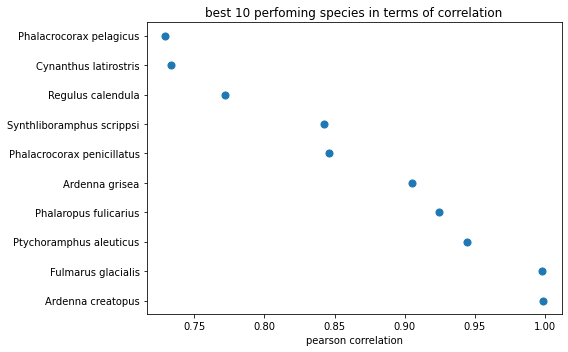

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(x=scores_corr,y=best_corr,s=50)
ax.invert_yaxis()
ax.set_title('best 10 perfoming species in terms of correlation')
ax.set_xlabel('pearson correlation')
fig.tight_layout()
plt.show()

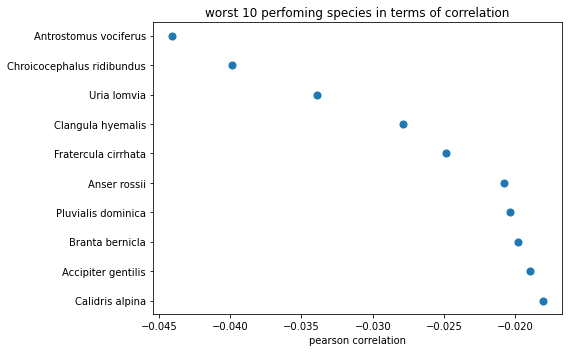

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(x=scores_corr_lowest,y=lowest_corr,s=50)
ax.invert_yaxis()
ax.set_title('worst 10 perfoming species in terms of correlation')
ax.set_xlabel('pearson correlation')
fig.tight_layout()
plt.show()

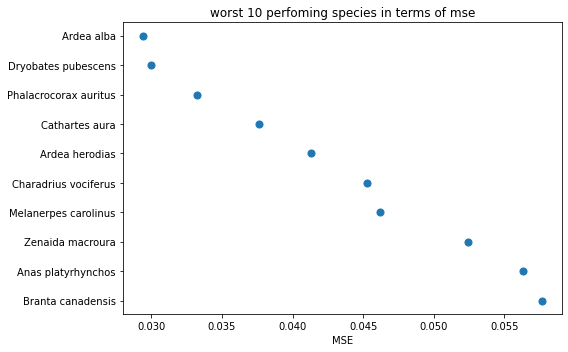

In [200]:
#MSE
scores_mse=np.array(mse_per_species)[torch.tensor(mse_per_species).argsort().numpy()[-10:]]
scores_mse_lowest=np.array(mse_per_species)[torch.tensor(mse_per_species).argsort().numpy()[:10]]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(x=scores_mse,y=best_mse,s=50)
ax.invert_yaxis()
ax.set_title('worst 10 perfoming species in terms of mse')
ax.set_xlabel('MSE')
fig.tight_layout()
plt.show()

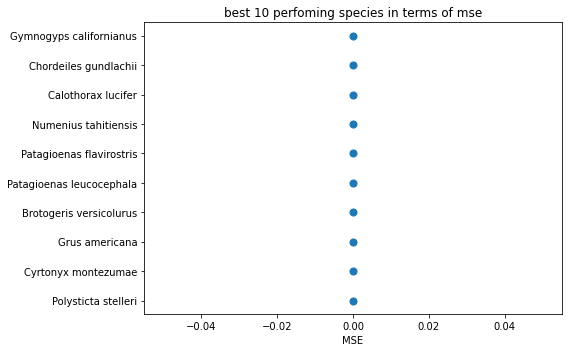

In [201]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(x=scores_mse_lowest,y=lowest_mse,s=50)
ax.invert_yaxis()
ax.set_title('best 10 perfoming species in terms of mse')
ax.set_xlabel('MSE')
fig.tight_layout()
plt.show()

In [202]:
# def plot_country_performance(df, model_names, title, xlabel):
#     CMAP_FN = plt.cm.get_cmap('tab20')
#     COUNTRY_YEAR_COLORS = [CMAP_FN.colors[i % 20] for i in range(len(subset_names))]

#     fig, ax = plt.subplots(1, 1, figsize=(12, 5))

#     for i, species in enumerate(best_corr):
#         r2s = scores_corr[i]
#         #size = len(country_indices[country]) / len(labels) * 1000
#         ax.scatter(x=r2s,  c=[COUNTRY_YEAR_COLORS[i]], label=species)

#     ax.invert_yaxis()  # invert direction to put best-performing models at the top
#     ax.grid(True)
#     ax.set_title(title)
#     ax.set_xlabel(xlabel)
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     fig.tight_layout()
#     plt.show()

# plot_country_performance(
#     df=country_r2_df,
#     model_names=list(agg_r2s.index),
#     title='Incountry Test Performance',
#     xlabel='test r^2')

In [61]:
#mse_per_species
#TODO deattach the list from cuda

In [51]:
preds_array.device

device(type='cuda', index=0)

In [118]:
#calculate top k
#topk_per_species=np.empty_like(mse_per_species)
topk_per_species=[]
i=0

for species in gt_t:
    nonzero = len(np.nonzero(species))
    if nonzero != 0 :
#         test_df.loc[i,"non_zero"] = nonzero
    
        indices_pred = (-preds_array_t[i]).argsort()[:nonzero]
        indices_gt = np.nonzero(gt_t)[0]

        topk_per_species.append(len([a for a in indices_pred if a in indices_gt])/nonzero)
    else:
        topk_per_species.append(-1)
    i+=1
    

In [120]:
#topk_per_species

In [203]:
#topk_per_species
#best and lowest species
lowest_topk=subset_names[torch.tensor(topk_per_species).argsort()[:10]]
best_topk=subset_names[torch.tensor(topk_per_species).argsort()[-10:]]
scores_lowest_topk=np.array(topk_per_species)[torch.tensor(topk_per_species).argsort().numpy()[:10]]
scores_higest_topk=np.array(topk_per_species)[torch.tensor(topk_per_species).argsort().numpy()[-10:]]

In [204]:
scores_lowest_topk,scores_higest_topk

(array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]),
 array([0.00437637, 0.00568182, 0.00628931, 0.00675676, 0.00772201,
        0.00796813, 0.00847458, 0.00952381, 0.01315789, 1.        ]))

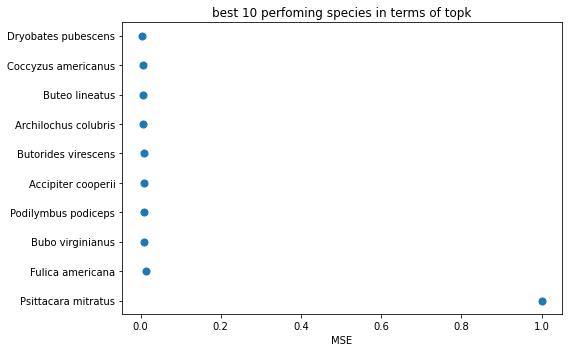

In [205]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(x=scores_higest_topk,y=best_topk,s=50)
ax.invert_yaxis()
ax.set_title('best 10 perfoming species in terms of topk')
ax.set_xlabel('MSE')
fig.tight_layout()
plt.show()

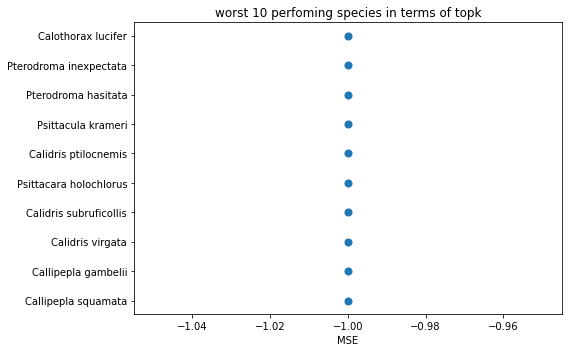

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(x=scores_lowest_topk,y=lowest_topk,s=50)
ax.invert_yaxis()
ax.set_title('worst 10 perfoming species in terms of topk')
ax.set_xlabel('MSE')
fig.tight_layout()
plt.show()

## Performance over all(spearman, pearson and R2scores) and per hotspot

In [148]:
#r2(torch.tensor(gt),torch.tensor(preds_array))


In [149]:
#corr(torch.tensor(gt),torch.tensor(preds_array))

In [131]:
#first perfomance overall:
r2_per_species=torch.mean(torch.tensor(r2(torch.tensor(gt),torch.tensor(preds_array))))
corr_per_species=torch.mean(torch.tensor(corr(torch.tensor(gt),torch.tensor(preds_array))))
rank_per_species=torch.mean(torch.tensor(rank(torch.tensor(gt),torch.tensor(preds_array))))

In [133]:
corr_per_species,rank_per_species

(tensor(nan), tensor(0.0663, dtype=torch.float64))

In [144]:
#per hotspot
mse=MultioutputWrapper(MeanSquaredError(), len(preds_array))
r2=MultioutputWrapper(R2Score(), len(preds_array))
corr=MultioutputWrapper(PearsonCorrCoef(), len(preds_array))
rank=MultioutputWrapper(SpearmanCorrCoef(),len(preds_array))
mse.to('cpu')
r2.to('cpu')
corr.to('cpu')
rank.to('cpu')
r2_per_hotspot=torch.tensor(r2(torch.tensor(gt_t),torch.tensor(preds_array_t)))
corr_per_hotspot=torch.tensor(corr(torch.tensor(gt_t),torch.tensor(preds_array_t)))
rank_per_hotspot=torch.tensor(rank(torch.tensor(gt_t),torch.tensor(preds_array_t)))

/tmp/ipykernel_6947/2939190457.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r2_per_hotspot=torch.tensor(r2(torch.tensor(gt_t),torch.tensor(preds_array_t)))
/tmp/ipykernel_6947/2939190457.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  corr_per_hotspot=torch.tensor(corr(torch.tensor(gt_t),torch.tensor(preds_array_t)))
/tmp/ipykernel_6947/2939190457.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rank_per_hotspot=torch.tensor(rank(torch.tensor(gt_t),torch.tensor(preds_array_t)))


In [145]:
test_df['corr']=corr_per_hotspot
test_df['rank_per_hotspot']=rank_per_hotspot

In [189]:
test_df["preds_corr"] = 7
test_df.loc[test_df["corr"]<0.85,"preds_corr"]  = 6
test_df.loc[test_df["corr"]<0.6,"preds_corr"]  = 5
test_df.loc[test_df["corr"]<0.4,"preds_corr"]  = 4
test_df.loc[test_df["corr"]<0.2,"preds_corr"]  = 3
test_df.loc[test_df["corr"]<0.1,"preds_corr"]  = 2
test_df.loc[test_df["corr"]<=-1,"preds_corr"]  = 0
test_df.loc[test_df["corr"]==0,"preds_corr"]  = 1
test_df.loc[test_df["corr"].isnull(),"preds_corr"]  = -1

In [186]:
test_df.loc[test_df["corr"].isnull()]

,hotspot_id,june_complete_checklists,rgb,species,maj_landuse,lon,lat,mae,mse,non_zero,topk,preds_,preds_corr,corr,rank_per_hotspot
763,L1369120,8,/network/scratch/t/tengmeli/scratch/ecosystem-...,/network/scratch/t/tengmeli/scratch/ecosystem-...,6,-120.203414,46.941378,2.696244,0.49795,0,-1.0,0.0,-1,NaN,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


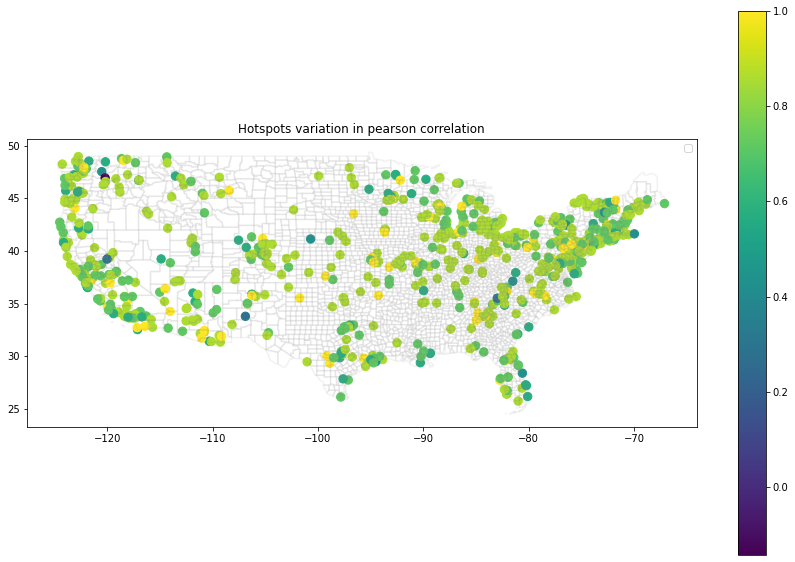

In [191]:

#plot variance across hotspots (corr, rank)
test_df["preds_corr"] = 7
test_df.loc[test_df["corr"]<0.85,"preds_corr"]  = 6
test_df.loc[test_df["corr"]<0.6,"preds_corr"]  = 5
test_df.loc[test_df["corr"]<0.4,"preds_corr"]  = 4
test_df.loc[test_df["corr"]<0.2,"preds_corr"]  = 3
test_df.loc[test_df["corr"]<0.1,"preds_corr"]  = 2
test_df.loc[test_df["corr"]<=-1,"preds_corr"]  = 0
test_df.loc[test_df["corr"]==0,"preds_corr"]  = 1
test_df.loc[test_df["corr"].isnull(),"preds_corr"]  = -1
# #train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
# geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )

# # produce a legend with the unique colors from the scatter
# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="lower left", title="Landuse class")
# ax.add_artist(legend)
test_df["preds_corr"]= test_df["preds_corr"]/7
tt=test_gdf.merge(test_df[["hotspot_id","mae","mse", "topk", "preds_corr"]], left_on = "hotspot_id",right_on = "hotspot_id")

fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
#gdf[gdf["split"]=="train"].plot(ax=ax,marker='*', color='yellowgreen', markersize=5, label = "train")
tt.plot(ax=ax, column ="preds_corr", marker='o', c=tt["preds_corr"], markersize=70, legend= True)

plt.legend()
plt.title("Hotspots variation in pearson correlation")
plt.show()